<a href="https://colab.research.google.com/github/molo-biloa/Exam-Group14-YIBS-2025/blob/main/Exam_Group14_YIBS_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Version 2 after debugging and initial successfful training**

In [ ]:
# Install required libraries
!pip install torch torchvision matplotlib kagglehub numpy

100%|██████████| 68.8M/68.8M [00:02<00:00, 29.5MB/s]

Extracting files...


100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 5.96MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 52.9MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.67MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Training data shape: (60000, 28, 28)
Test data shape: torch.Size([10000, 28, 28])


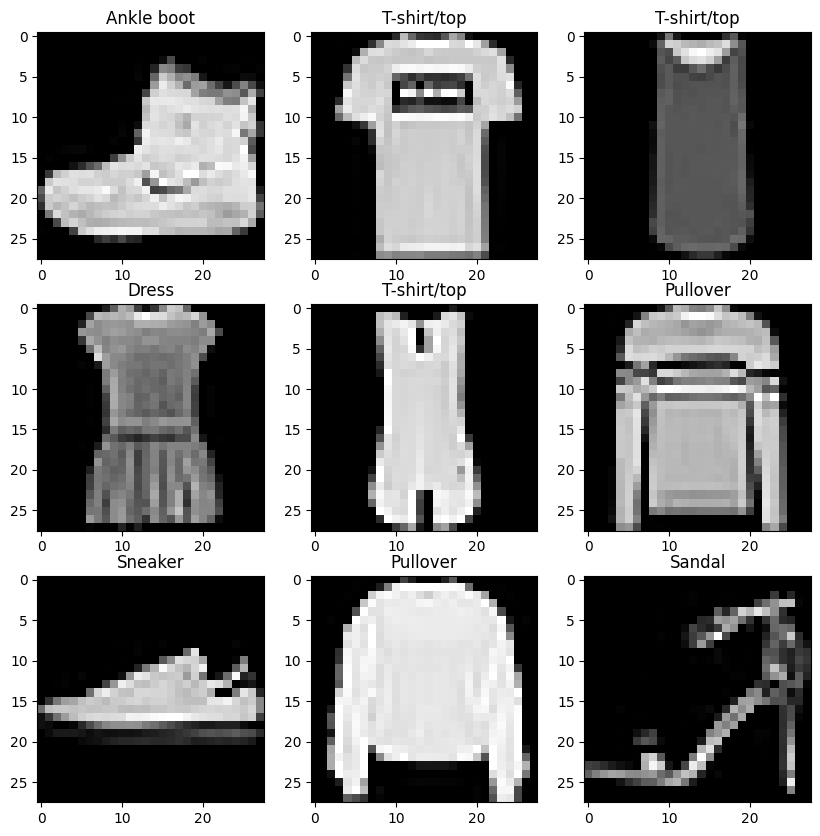


Epoch 1/10
--------------------
  Batch 100/938: Loss: 1.2393 | Accuracy: 55.64%
  Batch 200/938: Loss: 0.9856 | Accuracy: 63.97%
  Batch 300/938: Loss: 0.8763 | Accuracy: 68.01%
  Batch 400/938: Loss: 0.8127 | Accuracy: 70.16%
  Batch 500/938: Loss: 0.7686 | Accuracy: 71.72%
  Batch 600/938: Loss: 0.7355 | Accuracy: 72.97%
  Batch 700/938: Loss: 0.7055 | Accuracy: 74.08%
  Batch 800/938: Loss: 0.6832 | Accuracy: 74.94%
  Batch 900/938: Loss: 0.6637 | Accuracy: 75.70%

Epoch 1 Summary:
  Training Loss: 0.6550 | Training Accuracy: 76.02%
  Validation Loss: 0.4278 | Validation Accuracy: 84.66%
--------------------------------------------------

Epoch 2/10
--------------------
  Batch 100/938: Loss: 0.4689 | Accuracy: 83.12%
  Batch 200/938: Loss: 0.4724 | Accuracy: 82.92%
  Batch 300/938: Loss: 0.4702 | Accuracy: 83.07%
  Batch 400/938: Loss: 0.4658 | Accuracy: 83.21%
  Batch 500/938: Loss: 0.4640 | Accuracy: 83.33%
  Batch 600/938: Loss: 0.4598 | Accuracy: 83.56%
  Batch 700/938: Loss:

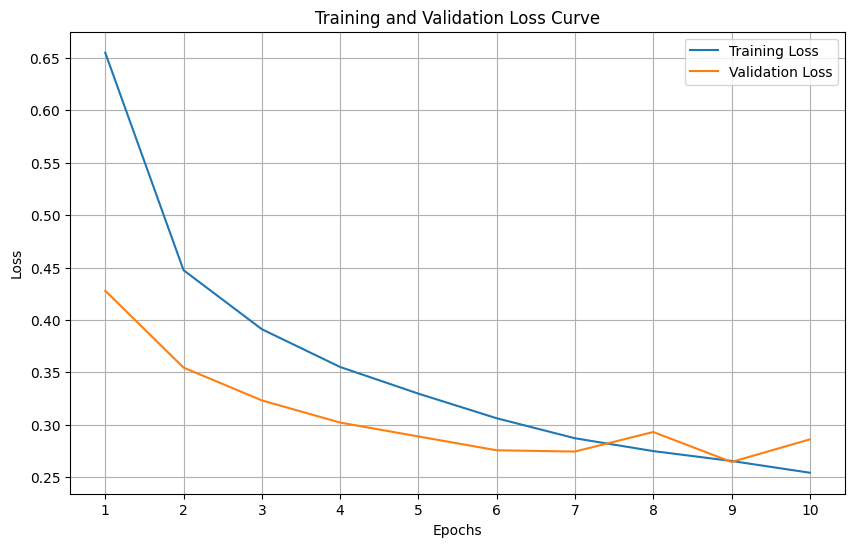


Final Test Results:
--------------------------------------------------
Test Accuracy: 90.13%

Model saved successfully!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import kagglehub

# Download Fashion-MNIST dataset
path = kagglehub.dataset_download("zalando-research/fashionmnist")

# Load dataset using PyTorch
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Convert to numpy arrays for visualization
train_images = train_data.data.numpy()
train_labels = train_data.targets.numpy()

# Explore dataset
print(f"Training data shape: {train_images.shape}")  # (60000, 28, 28)
print(f"Test data shape: {test_data.data.shape}")    # (10000, 28, 28)

# Plot sample images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(class_names[train_labels[i]])
plt.show()

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),    # (32, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(2),                   # (32, 13, 13)
            nn.Conv2d(32, 64, kernel_size=3),  # (64, 11, 11)
            nn.ReLU(),
            nn.MaxPool2d(2),                   # (64, 5, 5)
            nn.Flatten(),
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop with detailed logging
epochs = 10
train_losses = []  # Store training losses
val_losses = []    # Store validation losses

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 20)

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Print every 100 batches
        if (batch_idx + 1) % 100 == 0:
            current_loss = running_loss / total
            current_acc = 100 * correct / total
            print(f"  Batch {batch_idx+1}/{len(train_loader)}: "
                  f"Loss: {current_loss:.4f} | "
                  f"Accuracy: {current_acc:.2f}%")

    # Store training loss
    epoch_loss = running_loss / total
    train_losses.append(epoch_loss)

    # Epoch statistics
    epoch_acc = 100 * correct / total
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Training Loss: {epoch_loss:.4f} | "
          f"Training Accuracy: {epoch_acc:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Store validation loss
    val_loss = val_loss / val_total
    val_losses.append(val_loss)

    val_acc = 100 * val_correct / val_total
    print(f"  Validation Loss: {val_loss:.4f} | "
          f"Validation Accuracy: {val_acc:.2f}%")
    print("-" * 50)

# Generate loss chart after training
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, epochs+1))
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation
model.eval()
final_correct = 0
final_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        final_total += labels.size(0)
        final_correct += (predicted == labels).sum().item()

print("\nFinal Test Results:")
print("-" * 50)
print(f"Test Accuracy: {100 * final_correct / final_total:.2f}%")

# Save model
torch.save(model.state_dict(), 'fashion_mnist_cnn_v2.pth')
print("\nModel saved successfully!")

In [ ]:
ls

data/  fashion_mnist_cnn_v2.pth  sample_data/


In [ ]:
from google.colab import files
files.download("fashion_mnist_cnn_v2.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Version 3 with better Training and higher accuracy**

In [ ]:
!pip install torch torchvision matplotlib kagglehub numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

100%|██████████| 68.8M/68.8M [00:02<00:00, 31.7MB/s]

Extracting files...


100%|██████████| 26.4M/26.4M [00:00<00:00, 108MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 9.78MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 67.4MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.0MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Training data shape: (60000, 28, 28)
Test data shape: torch.Size([10000, 28, 28])


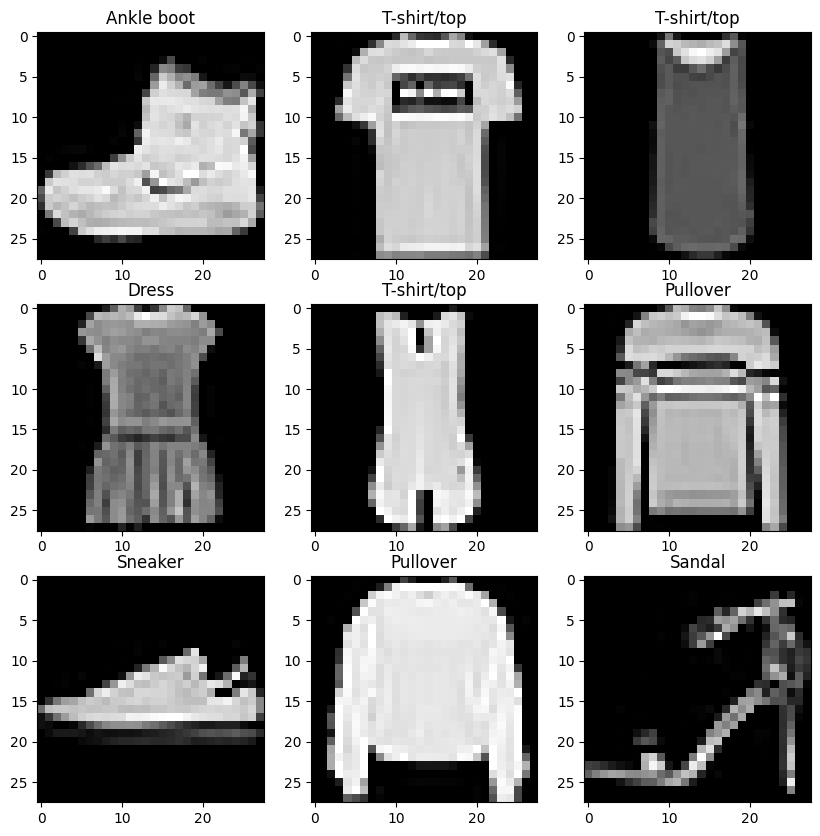

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 1/15
--------------------
  Batch 100/469: Loss: 0.8153 | Accuracy: 70.68%
  Batch 200/469: Loss: 0.6671 | Accuracy: 76.06%
  Batch 300/469: Loss: 0.5935 | Accuracy: 78.71%
  Batch 400/469: Loss: 0.5491 | Accuracy: 80.21%

Epoch 1 Summary:
  Training Loss: 0.5259 | Training Accuracy: 81.04%
  Validation Loss: 0.3353 | Validation Accuracy: 87.55%
--------------------------------------------------

Epoch 2/15
--------------------
  Batch 100/469: Loss: 0.3812 | Accuracy: 86.23%
  Batch 200/469: Loss: 0.3740 | Accuracy: 86.45%
  Batch 300/469: Loss: 0.3662 | Accuracy: 86.78%
  Batch 400/469: Loss: 0.3585 | Accuracy: 87.06%

Epoch 2 Summary:
  Training Loss: 0.3564 | Training Accuracy: 87.09%
  Validation Loss: 0.3076 | Validation Accuracy: 88.63%
--------------------------------------------------

Epoch 3/15
--------------------
  Batch 100/469: Loss: 0.3178 | Accuracy: 88.45%
  Batch 200/469: Loss: 0.3190 | Accuracy: 88.37%
  Batch 300/469: Loss: 0.3151 | Accuracy: 88.52%
  Batch 

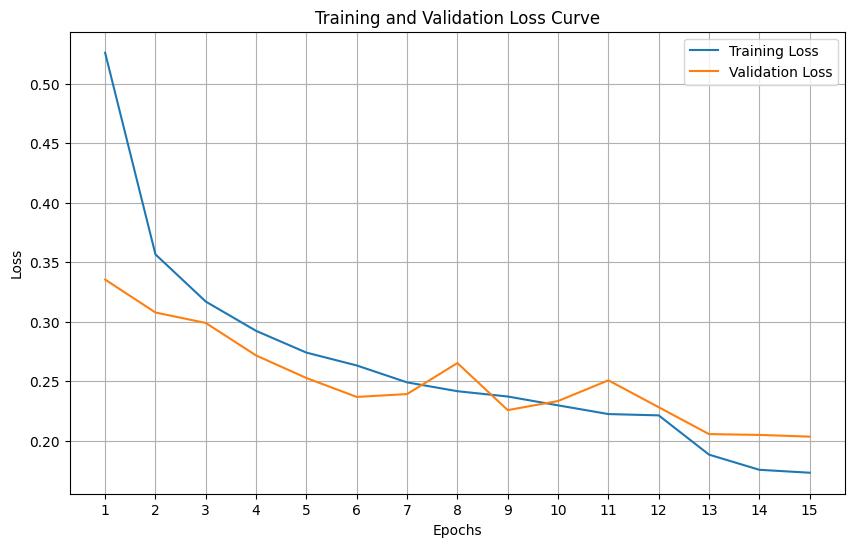


Final Test Results:
--------------------------------------------------
Test Accuracy: 92.93%

Model saved successfully!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import kagglehub

# Download Fashion-MNIST dataset
path = kagglehub.dataset_download("zalando-research/fashionmnist")

# Enhanced data transformations with normalization and augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),      # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load dataset using PyTorch
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Convert to numpy arrays for visualization
train_images = train_data.data.numpy()
train_labels = train_data.targets.numpy()

# Explore dataset
print(f"Training data shape: {train_images.shape}")  # (60000, 28, 28)
print(f"Test data shape: {test_data.data.shape}")    # (10000, 28, 28)

# Plot sample images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(class_names[train_labels[i]])
plt.show()

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)  # Increased batch size
test_loader = DataLoader(test_data, batch_size=128, num_workers=4)  # Increased batch size

# Enhanced CNN model with BatchNorm and deeper layers
class EnhancedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Keep spatial dimensions
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample to 14x14

            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample to 7x7

            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample to 3x3

            # Classifier
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),  # Increased hidden units
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)  # Learning rate scheduler

# Training loop with detailed logging
epochs = 15  # Increased epochs
train_losses = []  # Store training losses
val_losses = []    # Store validation losses

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 20)

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Print every 100 batches
        if (batch_idx + 1) % 100 == 0:
            current_loss = running_loss / total
            current_acc = 100 * correct / total
            print(f"  Batch {batch_idx+1}/{len(train_loader)}: "
                  f"Loss: {current_loss:.4f} | "
                  f"Accuracy: {current_acc:.2f}%")

    # Store training loss
    epoch_loss = running_loss / total
    train_losses.append(epoch_loss)

    # Epoch statistics
    epoch_acc = 100 * correct / total
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Training Loss: {epoch_loss:.4f} | "
          f"Training Accuracy: {epoch_acc:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Store validation loss
    val_loss = val_loss / val_total
    val_losses.append(val_loss)

    val_acc = 100 * val_correct / val_total
    print(f"  Validation Loss: {val_loss:.4f} | "
          f"Validation Accuracy: {val_acc:.2f}%")
    print("-" * 50)

    # Learning rate scheduler step
    scheduler.step(val_loss)

# Generate loss chart after training
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, epochs+1))
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation
model.eval()
final_correct = 0
final_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        final_total += labels.size(0)
        final_correct += (predicted == labels).sum().item()

print("\nFinal Test Results:")
print("-" * 50)
print(f"Test Accuracy: {100 * final_correct / final_total:.2f}%")

# Save model
torch.save(model.state_dict(), 'fashion_mnist_cnn_v3.pth')
print("\nModel saved successfully!")